In [2]:
import torch
from torch import (optim, nn)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    LogisticRegression,
    Trainer
)

# User-defined functions
from utils.preprocess import clusters, onehot

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [3]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 20
SIZE = 100
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
X, y = clusters(SIZE, means=[(-3, -3), (2, 2), (-2, 2)], stds=[0.8, 0.6, 0.7])

In [5]:
print("Generated X:", X, "\nGenerated y:", y, sep='\n')
print("\nShape of X: ", X.shape, "\nShape of y: ", y.shape, sep='\n')

Generated X:
tensor([[-1.9094, -3.2674],
        [-2.4524, -2.1261],
        [-2.4515, -3.5192],
        [-3.8383, -3.4925],
        [-2.7518, -3.2086],
        [-3.5467, -3.5860],
        [-3.3392, -4.2272],
        [-3.6976, -3.8489],
        [-4.8954, -2.5813],
        [-3.3547, -3.8083],
        [-2.4625, -2.2221],
        [-3.6698, -3.4747],
        [-3.1631, -3.0910],
        [-2.4563, -3.1804],
        [-2.8987, -2.5654],
        [-2.0998, -5.0173],
        [-3.6373, -2.8880],
        [-4.1502, -3.7252],
        [-3.8273, -4.2240],
        [-3.5111, -2.8118],
        [-2.6205, -1.7491],
        [-4.0437, -1.4650],
        [-3.8492, -2.1714],
        [-1.8667, -3.7600],
        [-4.2188, -2.5508],
        [-2.8262, -1.5744],
        [-4.1095, -3.0597],
        [-2.0751, -5.1447],
        [-3.1189, -3.6522],
        [-2.2550, -4.5931],
        [-2.7038, -3.1549],
        [-4.7422, -2.0556],
        [-4.1212, -3.6917],
        [-1.0384, -2.8893],
        [-4.2385, -1.9106],
       

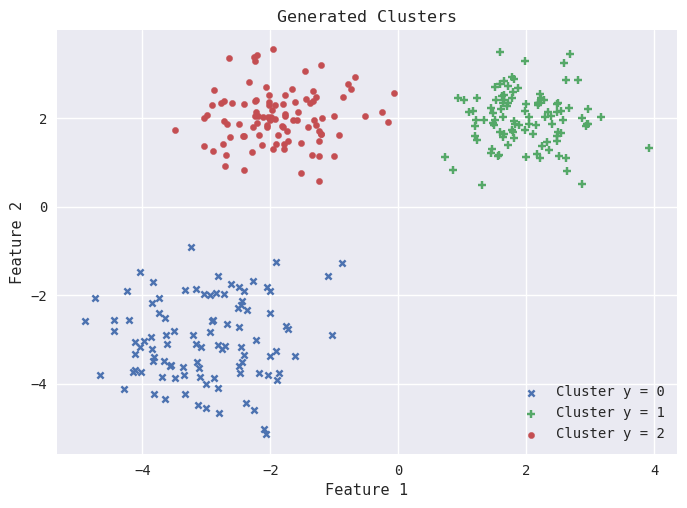

In [6]:
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], marker='x', label='Cluster y = 0', s=20)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='+', label='Cluster y = 1', s=40)
plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], marker='o', label='Cluster y = 2', s=20)
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Generated Clusters')
plt.show()

In [7]:
y_encoded = onehot(y.int(), 3)
print(f"New y (One-Hot Encoded):\n{y_encoded}")

New y (One-Hot Encoded):
tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
       

In [8]:
Model = LogisticRegression(in_dims=2, out_dims=3, multinomial=True).to(DEVICE)

In [9]:
Data = TensorDataset(X, y_encoded)
Data.tensors

(tensor([[-1.9094, -3.2674],
         [-2.4524, -2.1261],
         [-2.4515, -3.5192],
         [-3.8383, -3.4925],
         [-2.7518, -3.2086],
         [-3.5467, -3.5860],
         [-3.3392, -4.2272],
         [-3.6976, -3.8489],
         [-4.8954, -2.5813],
         [-3.3547, -3.8083],
         [-2.4625, -2.2221],
         [-3.6698, -3.4747],
         [-3.1631, -3.0910],
         [-2.4563, -3.1804],
         [-2.8987, -2.5654],
         [-2.0998, -5.0173],
         [-3.6373, -2.8880],
         [-4.1502, -3.7252],
         [-3.8273, -4.2240],
         [-3.5111, -2.8118],
         [-2.6205, -1.7491],
         [-4.0437, -1.4650],
         [-3.8492, -2.1714],
         [-1.8667, -3.7600],
         [-4.2188, -2.5508],
         [-2.8262, -1.5744],
         [-4.1095, -3.0597],
         [-2.0751, -5.1447],
         [-3.1189, -3.6522],
         [-2.2550, -4.5931],
         [-2.7038, -3.1549],
         [-4.7422, -2.0556],
         [-4.1212, -3.6917],
         [-1.0384, -2.8893],
         [-4.2

In [10]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, generator=GENERATOR, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, generator=GENERATOR, shuffle=True)

In [11]:
trainer = Trainer(
    Model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(Model.parameters(), lr=.1),
    criterion=nn.CrossEntropyLoss(reduction='mean'),        # Cross-entropy Loss (For classification)
    device=DEVICE
)

In [12]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

: 100%|██████████| 8/8 [00:00<00:00, 28.64it/s]


Loss: 1.1011
	| Validation Loss: 1.1012



: 100%|██████████| 8/8 [00:00<00:00, 1000.07it/s]


Loss: 0.9785
	| Validation Loss: 0.9910



: 100%|██████████| 8/8 [00:00<00:00, 500.01it/s]


Loss: 0.8465
	| Validation Loss: 0.8027



: 100%|██████████| 8/8 [00:00<00:00, 421.08it/s]


Loss: 0.7031
	| Validation Loss: 0.6818



: 100%|██████████| 8/8 [00:00<00:00, 666.44it/s]


Loss: 0.6446
	| Validation Loss: 0.6460



: 100%|██████████| 8/8 [00:00<00:00, 615.41it/s]


Loss: 0.6231
	| Validation Loss: 0.6294



: 100%|██████████| 8/8 [00:00<00:00, 666.69it/s]


Loss: 0.6127
	| Validation Loss: 0.6194



: 100%|██████████| 8/8 [00:00<00:00, 333.34it/s]


Loss: 0.6057
	| Validation Loss: 0.6139



: 100%|██████████| 8/8 [00:00<00:00, 517.15it/s]


Loss: 0.6002
	| Validation Loss: 0.6081



: 100%|██████████| 8/8 [00:00<00:00, 432.11it/s]


Loss: 0.5961
	| Validation Loss: 0.6046



: 100%|██████████| 8/8 [00:00<00:00, 592.06it/s]


Loss: 0.5922
	| Validation Loss: 0.6025



: 100%|██████████| 8/8 [00:00<00:00, 351.61it/s]


Loss: 0.5909
	| Validation Loss: 0.5979



: 100%|██████████| 8/8 [00:00<00:00, 494.32it/s]


Loss: 0.5872
	| Validation Loss: 0.5966



: 100%|██████████| 8/8 [00:00<00:00, 727.29it/s]


Loss: 0.5854
	| Validation Loss: 0.5947



: 100%|██████████| 8/8 [00:00<00:00, 592.50it/s]


Loss: 0.5832
	| Validation Loss: 0.5942



: 100%|██████████| 8/8 [00:00<00:00, 666.62it/s]


Loss: 0.5812
	| Validation Loss: 0.5926



: 100%|██████████| 8/8 [00:00<00:00, 615.43it/s]


Loss: 0.5807
	| Validation Loss: 0.5911



: 100%|██████████| 8/8 [00:00<00:00, 444.40it/s]


Loss: 0.5788
	| Validation Loss: 0.5896



: 100%|██████████| 8/8 [00:00<00:00, 615.43it/s]


Loss: 0.5787
	| Validation Loss: 0.5885



: 100%|██████████| 8/8 [00:00<00:00, 773.30it/s]

Loss: 0.5773
	| Validation Loss: 0.5870



In [13]:
print("Train Loss:", train_loss, "\nValidation Loss:", val_loss, sep='\n')

Train Loss:
{0: 1.1010857969522476, 1: 0.9785462915897369, 2: 0.8464864492416382, 3: 0.7030617892742157, 4: 0.6445814743638039, 5: 0.6231128051877022, 6: 0.6127076148986816, 7: 0.6056586876511574, 8: 0.6001534536480904, 9: 0.5961239635944366, 10: 0.592184029519558, 11: 0.5908569991588593, 12: 0.5872204974293709, 13: 0.5854225680232048, 14: 0.5831760689616203, 15: 0.5812304690480232, 16: 0.5806670561432838, 17: 0.5788279250264168, 18: 0.5786936059594154, 19: 0.5773417577147484}

Validation Loss:
{0: 1.1012031435966492, 1: 0.991033136844635, 2: 0.8027074038982391, 3: 0.6818194389343262, 4: 0.6460338532924652, 5: 0.6293844282627106, 6: 0.6194280683994293, 7: 0.6138841807842255, 8: 0.6081325709819794, 9: 0.6045631170272827, 10: 0.602520227432251, 11: 0.5979004502296448, 12: 0.596640020608902, 13: 0.5946816205978394, 14: 0.5941539704799652, 15: 0.5925675630569458, 16: 0.5910588204860687, 17: 0.5895817875862122, 18: 0.5884702205657959, 19: 0.5870210528373718}


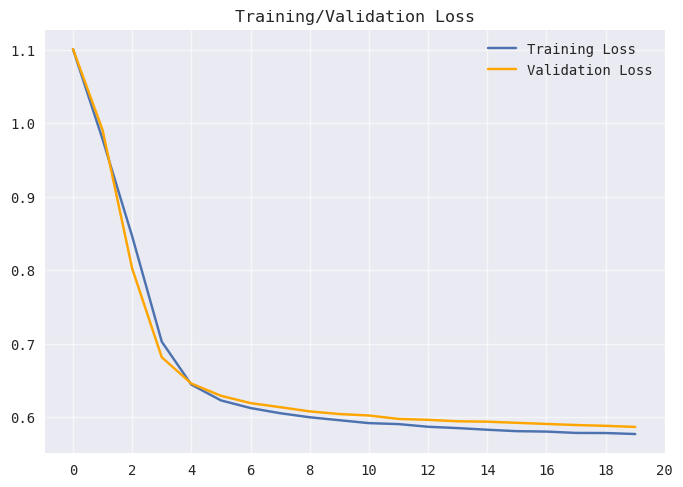

In [14]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.xticks(np.linspace(0, 20, 11));
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()

In [15]:
print(f"Predicted Model Parameters:", "Weights: {}".format(Model.linear.weight), "Bias: {}".format(Model.linear.bias), sep="\n")

Predicted Model Parameters:
Weights: Parameter containing:
tensor([[-0.1280, -0.9611],
        [ 1.4340,  0.6957],
        [-0.7652,  0.9949]], device='cuda:0', requires_grad=True)
Bias: Parameter containing:
tensor([ 0.4072, -0.2825, -0.5070], device='cuda:0', requires_grad=True)


In [16]:
print(f"Shapes for Weight and Bias Tensors:", Model.linear.weight.shape, Model.linear.bias.shape, sep="\n")

Shapes for Weight and Bias Tensors:
torch.Size([3, 2])
torch.Size([3])


In [17]:
weights = Model.linear.weight.detach().cpu().numpy()
biases = Model.linear.bias.detach().cpu().numpy()

Xmin, Xmax = X[:, 0].min() - .5, X[:, 0].max() + .5
ymin, ymax = X[:, 1].min() - .5, X[:, 1].max() + .5

In [18]:
xx, yy = np.meshgrid(np.linspace(Xmin, Xmax, SIZE), np.linspace(ymin, ymax, SIZE))
grid = np.c_[xx.flatten(), yy.flatten()]

scores = grid @ weights.T + biases

In [19]:
predicted_classes = np.argmax(scores, axis=1).reshape(xx.shape)

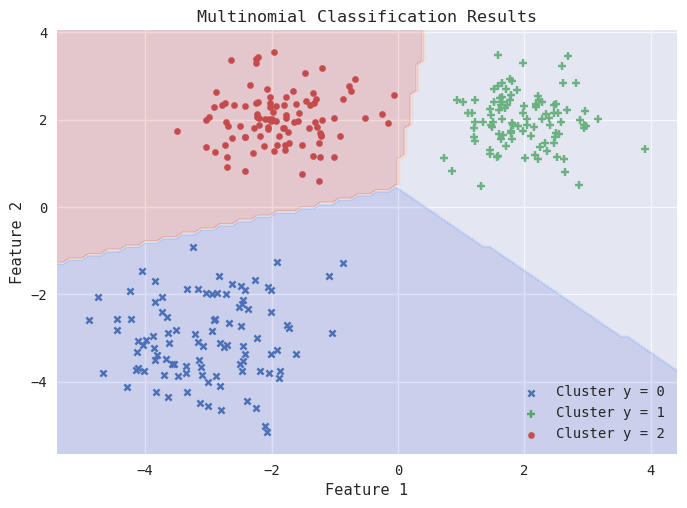

In [20]:
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], marker='x', label='Cluster y = 0', s=20)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='+', label='Cluster y = 1', s=40)
plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], marker='o', label='Cluster y = 2', s=20)

plt.contourf(xx, yy, predicted_classes, alpha=0.2, cmap=plt.cm.coolwarm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title("Multinomial Classification Results");
plt.legend(loc='lower right');
plt.show();

In [21]:
# Testing on a New Instance
Xn = torch.tensor([-3.77690, 0.007854], dtype=DTYPE, device='cpu').unsqueeze(0)
print(f"New Instance:", Xn, Xn.shape, sep='\n')

New Instance:
tensor([[-3.7769,  0.0079]])
torch.Size([1, 2])


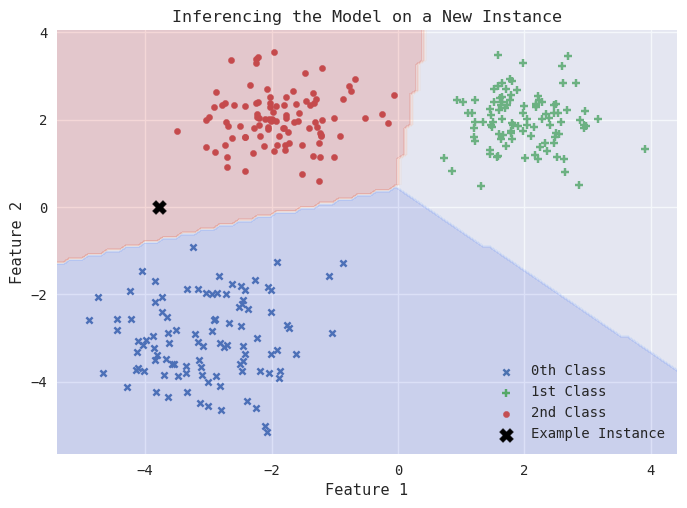

In [22]:
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], marker='x', label='0th Class', s=20)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='+', label='1st Class', s=40)
plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], marker='o', label='2nd Class', s=20)

plt.contourf(xx, yy, predicted_classes, alpha=0.2, cmap=plt.cm.coolwarm)

# New instance
plt.scatter(Xn[:, 0], Xn[:, 1], marker='X', label="Example Instance", s=100, c='black')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title("Inferencing the Model on a New Instance");
plt.legend(loc='lower right');
plt.show();

In [24]:
yn = Model(Xn.to(DEVICE))
print(f"Resulting predictions:\n{yn}")
print(f"Shape of prediction tensor: {yn.shape}")

Resulting predictions:
tensor([[1.8126e-01, 2.5253e-04, 8.1849e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Shape of prediction tensor: torch.Size([1, 3])


In [25]:
probs = [f"{prob.item() * 100:.2f}%" for prob in yn.squeeze()]
print("Probabilities:", probs, sep='\n')

Probabilities:
['18.13%', '0.03%', '81.85%']


In [26]:
torch.argmax(yn, dim=1)

tensor([2], device='cuda:0')